Federico Manenti: 790032

Matteo Licciardello: 799368

# Processing di segnali bi-dimensionali


## Import librerie

In [2]:
%tensorflow_version  2.x
! pip install -q keras==2.3.0

TensorFlow 2.x selected.
     |████████████████████████████████| 378kB 9.4MB/s 


In [1]:
!pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-xv51_x5c
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-xv51_x5c
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8311 sha256=9b2b31ac6ee0f455cb4f6cc721da523a613773e2005bd05096fd8edb1cc3e1a1
  Stored in directory: /tmp/pip-ephem-wheel-cache-6t3fld23/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [3]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix
from keras.utils import to_categorical
from keras import layers, optimizers, callbacks, Model, losses, models
from keras.preprocessing.image import ImageDataGenerator
from sklearn.svm import SVC
from keras.preprocessing import image as kimage

from sklearn.neighbors import KDTree
from keras_vggface.vggface import VGGFace
from keras_vggface import utils
import scipy as sp

Using TensorFlow backend.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Definisco la directory nel mio Drive da cui saranno prelevati i dati
dir_drive = "/content/drive/My Drive/progetto_dsim/data/facce/"

#Definisco le categorie associate alle cartelle-immagini
category = ["fede", "liccia"]

## Preprocessing dati

In [0]:
IMG_SIZE = 255

def create_data():
    for cat in category:
        path = os.path.join(dir_drive, cat)
        class_num = category.index(cat)

        for img in tqdm(os.listdir(path)):
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)
                img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                features.append(img_array)
                labels.append(class_num)
            except Exception as e:
                pass

In [7]:
features = []
labels = []

create_data()

100%|██████████| 200/200 [00:59<00:00,  3.61it/s]


In [8]:
print('Numero immagini: ' + str(len(features)) + 
      '\nDimensioni: ' + str(features[0].shape))

Numero immagini: 400
Dimensioni: (255, 255)


In [0]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=42)

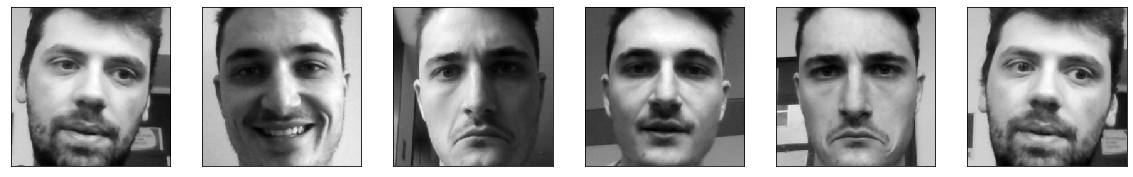

In [10]:
n = 6
plt.figure(figsize=(20, 15))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_train[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## Data augmentation

In [0]:
datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.1,
        brightness_range = (0.5,1.5),
        horizontal_flip=True,
        fill_mode='nearest')

In [0]:
aug = datagen.flow(np.array(X_train).reshape(-1, IMG_SIZE, IMG_SIZE, 1), y_train)

In [0]:
aug = datagen.flow(np.array(X_train[1].reshape(1,255,255,1)))

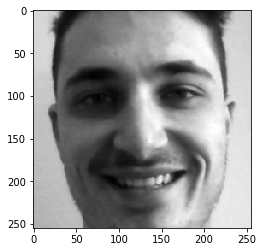

In [43]:
plt.imshow(X_train[1])

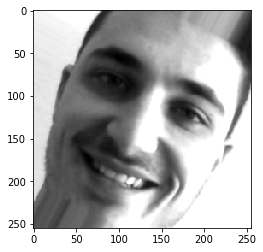

In [51]:
plt.imshow(aug[0].squeeze())

In [46]:
dati_aug = np.vstack((aug[0][0], aug[1][0]))
for i in tqdm(range(2,len(aug))):
    dati_aug = np.vstack((dati_aug, aug[i][0]))


label_aug = np.hstack((aug[0][1], aug[1][1]))
for i in tqdm(range(2,len(aug))):
    label_aug = np.hstack((label_aug, aug[i][1]))

ValueError: ignored

In [0]:
for i in dati_aug.squeeze():
    X_train.append(i)

y_train = y_train + list(label_aug)

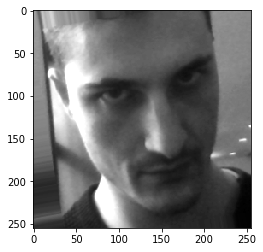

In [20]:
plt.imshow(dati_aug[1].squeeze())

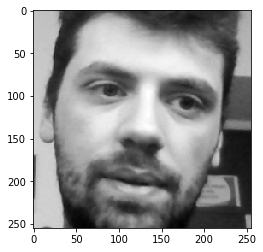

In [16]:
plt.imshow(X_train[0])

## Addestramento CNN

In [0]:
X_train = np.array(list(X_train)).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_train = X_train / 255.0
X_test = np.array(list(X_test)).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_test = X_test / 255.0

y_train = np.array(y_train)
y_test = np.array(y_test)

In [0]:
model = models.Sequential()

model.add(layers.Conv2D(8, (2,2), activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

In [0]:
j = 0

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 254, 254, 8)       40        
_________________________________________________________________
batch_normalization_2 (Batch (None, 254, 254, 8)       32        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 127, 127, 8)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 127, 127, 8)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 129032)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                2064528   
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)               

In [0]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.adam(),
              metrics=['acc'])

In [0]:
mc = callbacks.ModelCheckpoint(filepath="/content/drive/My Drive/progetto_dsim/modelli/face_recognition/model" + str(j) + ".hdf5" ,
                               monitor="val_loss",
                               save_best_only = True)


history = model.fit(X_train, y_train,
                    batch_size=16,
                    epochs=50,
                    validation_split=0.2)
                    #callbacks = [mc])
                    

j += 1

Train on 576 samples, validate on 144 samples
Epoch 1/50
576/576 [==============================] - 1s 2ms/step - loss: 2.6632 - acc: 0.7726 - val_loss: 0.8838 - val_acc: 0.5208
Epoch 2/50
576/576 [==============================] - 1s 2ms/step - loss: 0.3622 - acc: 0.8889 - val_loss: 0.5784 - val_acc: 0.6250
Epoch 3/50
576/576 [==============================] - 1s 2ms/step - loss: 0.2010 - acc: 0.9184 - val_loss: 0.6632 - val_acc: 0.6389
Epoch 4/50
576/576 [==============================] - 1s 2ms/step - loss: 0.1940 - acc: 0.9323 - val_loss: 0.5725 - val_acc: 0.7153
Epoch 5/50
576/576 [==============================] - 1s 2ms/step - loss: 0.2868 - acc: 0.9340 - val_loss: 0.6387 - val_acc: 0.5972
Epoch 6/50
576/576 [==============================] - 1s 2ms/step - loss: 0.1649 - acc: 0.9462 - val_loss: 0.6179 - val_acc: 0.6458
Epoch 7/50
576/576 [==============================] - 1s 2ms/step - loss: 0.0858 - acc: 0.9566 - val_loss: 0.6131 - val_acc: 0.7222
Epoch 8/50
576/576 [==========

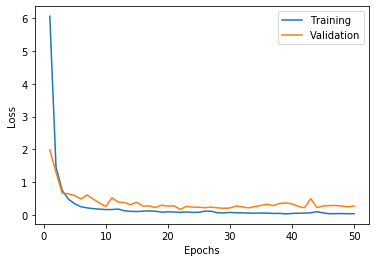

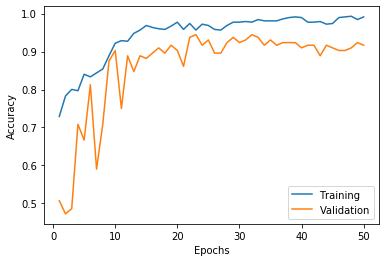

In [0]:
x_plot = list(range(1,history.epoch[-1]+2))

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])
    
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['acc'])
    plt.plot(x_plot, network_history.history['val_acc'])
    plt.legend(['Training', 'Validation'])

plot_history(history)

## Test CNN

In [0]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("TEST LOSS:", test_loss)
print("TEST ACCURACY:", test_acc)

40/40 [==============================] - 0s 786us/step
TEST LOSS: 0.00010881532944040373
TEST ACCURACY: 1.0


In [0]:
print(classification_report(y_test, model.predict_classes(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        19

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



In [0]:
prova = models.load_model("/content/drive/My Drive/progetto_dsim/modelli/face_recognition/model0.hdf5")

In [0]:
prova.evaluate(X_test, y_test)

40/40 [==============================] - 7s 176ms/step


[0.0023396383272483944, 1.0]

In [0]:
prova.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 254, 254, 8)       40        
_________________________________________________________________
batch_normalization_28 (Batc (None, 254, 254, 8)       32        
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 127, 127, 8)       0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 127, 127, 8)       0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 129032)            0         
_________________________________________________________________
dense_38 (Dense)             (None, 16)                2064528   
_________________________________________________________________
dropout_42 (Dropout)         (None, 16)              

## Classe di rigetto


### Preprocessing

In [0]:
IMG_SIZE = 255

def create_data_color():
    for cat in category:
        path = os.path.join(dir_drive, cat)
        class_num = category.index(cat)

        for img in tqdm(os.listdir(path)):
            try:
                img_array = kimage.load_img(os.path.join(path,img), target_size=(IMG_SIZE, IMG_SIZE))
                img_array = kimage.img_to_array(img_array)
                img_array = np.expand_dims(img_array, axis=0)
                img_array = utils.preprocess_input(img_array, version=2)
                features.append(img_array)
                labels.append(class_num)
            except Exception as e:
                pass

In [0]:
features = []
labels = []

create_data_color()

100%|██████████| 200/200 [00:00<00:00, 311.56it/s]


In [0]:
features = np.array(list(features)).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
labels = np.array(labels)

### Import VGG-Face

In [0]:
# resnet on face
IMG_SIZE = 255
net = VGGFace(model='resnet50',
              include_top=False,
              pooling='avg',
              input_shape=(IMG_SIZE, IMG_SIZE, 3))

In [0]:
net.summary()

Model: "vggface_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 255, 255, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 128, 128, 64) 9408        input_2[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 128, 128, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 128, 128, 64) 0           conv1/7x7_s2/bn[0][0]            
___________________________________________________________________________________

### Calcolo features medie

In [0]:
fede = net.predict(features[0:200])
liccia = net.predict(features[200:400])

fede_mean = fede.mean(axis=0)
liccia_mean = liccia.mean(axis=0)

In [0]:
np.save('/content/drive/My Drive/progetto_dsim/consegna/fede_mean', fede_mean)
np.save('/content/drive/My Drive/progetto_dsim/consegna/liccia_mean', liccia_mean)

In [0]:
sp.spatial.distance.euclidean(fede_mean, liccia_mean)

108.39954376220703